# Calibration of Systematic Deviations Caused by the Control Hardware

Written by Julian Teske. Special thanks to Joan Mercade and Mark Elo from
Tabor instruments for providing the measurement data using a Proteus AWG.

This notebook discusses the necessity and the features to include control
hardware into qopt simulations and pulse optimization.

We simulate a single qubit with the model Hamiltonian
\begin{equation}
H = J(\epsilon) \sigma_Z + \Delta B_Z \sigma_X + \delta_B \sigma_X
\end{equation}

derived from a singlet-triplet qubit realized by two electrons in a double
quantum dot, where $\sigma$ denotes a Pauli matrix, $\epsilon$ a
voltage-controlled detuning of the double quantum dot, $J(\epsilon)=J_0
e^{\epsilon/\epsilon_0 }$ the exchange energy, $\Delta B_Z$ the magnetic field
gradient and $\delta_B$ quasi static noise on the magnetic field.

In [1]:
# date 10th of June 2021
# current qopt version 1.1 (to 1.2 master branch)
from qopt import *
import copy
import numpy as np
import matplotlib.pyplot as plt


# The Constants are realistic for GaAs singlet-triplet qubits.

eps_0 = .27
j_0 = 1
x_pi = (.5 * DenseOperator.pauli_x()).exp(tau=np.pi * 1j)

total_time_pulse_default = 15
n_time_steps_default = 15
time_pulse_default = total_time_pulse_default / n_time_steps_default * np.ones(
    n_time_steps_default)
dbz = 1.5 * 2 * np.pi / total_time_pulse_default

def exchange_energy(eps):
    return j_0 * np.exp(eps / eps_0)

def exchange_energy_deriv(eps):
    return j_0 / eps_0 * np.exp(eps / eps_0)

amp_func_exchange = UnaryAnalyticAmpFunc(
    value_function=exchange_energy,
    derivative_function=exchange_energy_deriv
)

def create_solver(transfer_func = None,
                  n_time_steps = n_time_steps_default,
                  time_pulse = n_time_steps_default,
                  initial_state = None):
    ntg = NTGQuasiStatic(
        standard_deviation=[.03],
        n_samples_per_trace=n_time_steps,
        n_traces=6
    )

    temp_solver = SchroedingerSMonteCarlo(
        h_ctrl=[.5 * DenseOperator.pauli_z()],
        h_drift=[dbz * .5 * DenseOperator.pauli_x()],
        h_noise=[.5 * DenseOperator.pauli_x()],
        noise_trace_generator=ntg,
        tau=time_pulse,
        amplitude_function=amp_func_exchange,
        transfer_function=transfer_func,
        initial_state=initial_state
    )
    return temp_solver

def create_optimizer(
        transfer_func = None,
        n_time_steps = n_time_steps_default,
        time_pulse = time_pulse_default
):
    solver = create_solver(
        transfer_func=transfer_func,
        n_time_steps=n_time_steps,
        time_pulse=time_pulse
    )

    syst_costs = OperationInfidelity(
        solver=solver,
        target=x_pi
    )
    incoherent_costs = OperationNoiseInfidelity(
        solver=solver,
        target=x_pi
    )
    simulator = Simulator(
        solvers=[solver, ],
        cost_fktns=[syst_costs, incoherent_costs]
    )
    temp_optimizer = ScalarMinimizingOptimizer(
        system_simulator=simulator,
        bounds=[[-5 * eps_0, 2 * eps_0]] * n_time_steps,
        cost_fktn_weights=[1, 1e1]
    )
    return temp_optimizer


We start the simulation without including the control electronics.

<AxesSubplot:xlabel='Iteration', ylabel='Costs'>

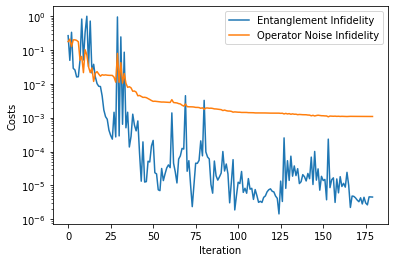

In [2]:
optimizer = create_optimizer()
np.random.seed(0)
initial_pulse = np.random.rand(n_time_steps_default, 1) - 1
result = optimizer.run_optimization(initial_pulse)

data = DataContainer()
data.append_optim_result(result)
analyser = Analyser(data)
analyser.plot_costs()

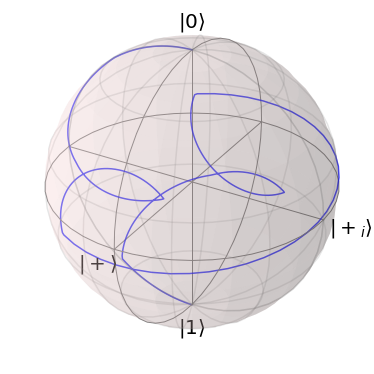

In [3]:
optimizer.system_simulator.solvers[0].plot_bloch_sphere()


## Apply an AWG Generated Pulse

In a naive approach, we try to generate the time optimized pulse with an AWG.
Joan Mercade used a Proteus AWG of Tabor electronics to create this pulse using
two different methods.

A: The pulse is created using the baseband and IQ-Modulation.

B: Direct RF generation in the First Nyquist Band. This requires an
additional 4x oversampling but allows the use of a bandpass filter.


In [4]:

data_file = "quantumdotsgood_High_Amplitude.txt"
with open(data_file) as f:
    lines = f.readlines()

realistic_pulse = np.vectorize(float)(np.asarray(lines))
shift = int(2.5 * 20 * 16)
realistic_pulse_cut = realistic_pulse[shift : - shift]
realistic_pulse_samples = realistic_pulse.size
realistic_pulse_dt = 20 / realistic_pulse_samples
realistic_pulse_time = (1 / 20 / 16) * np.ones(
    realistic_pulse_samples // 20 * 15)

In [5]:
# This solver can be used to plot the optimal pulse for comparison.

oversampling_tf = OversamplingTF(
    oversampling=20 * 16
)
optimizer = create_optimizer(oversampling_tf)
solver_compare = optimizer.system_simulator.solvers[0]
solver_compare.set_optimization_parameters(result.final_parameters)


In [6]:
# A linear transformation is required.

a = 2.5
b = -.46
realistic_pulse_cut_lin_transferred = a * realistic_pulse_cut + b

We can see that the generated pulse resembles the optimal pulse quite closely.

Text(0, 0.5, 'Voltage (mV)')

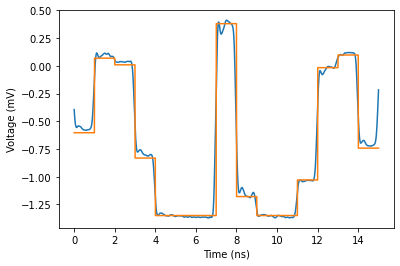

In [7]:
plt.plot(np.cumsum(realistic_pulse_time),
                     realistic_pulse_cut_lin_transferred)
plt.plot(np.cumsum(realistic_pulse_time),
                     solver_compare.transferred_parameters)
plt.xlabel("Time (ns)")
plt.ylabel('Voltage (mV)')

The deviation in the resulting pulse is detrimental. The resulting infidelity
is much to high for any application.

array([0.17456899, 0.00133106])

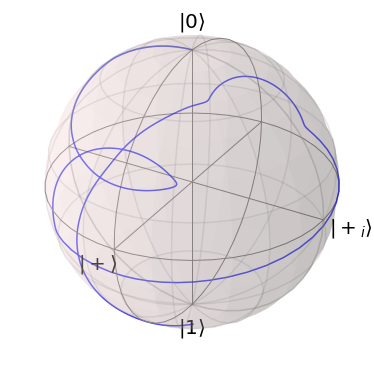

In [8]:
optimizer_long_pulse = create_optimizer(
    n_time_steps=realistic_pulse_samples // 20 * 15,
    time_pulse=realistic_pulse_time)
solver_long = optimizer_long_pulse.system_simulator.solvers[0]
solver_long.set_optimization_parameters(np.expand_dims(
    realistic_pulse_cut_lin_transferred, axis=1))

solver_long.plot_bloch_sphere()

optimizer_long_pulse.system_simulator.wrapped_cost_functions(np.expand_dims(
    realistic_pulse_cut_lin_transferred, axis=1))


We continue with method B and observe that the AWG generated a much smoother
pulse.

Text(0, 0.5, 'Voltage (mV)')

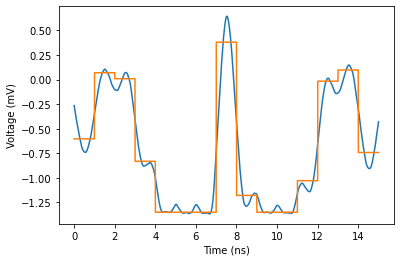

In [9]:
data_file = "quantumdotsgood_4x.txt"
with open(data_file) as f:
    lines = f.readlines()
realistic_pulse = np.vectorize(float)(np.asarray(lines))
realistic_pulse_cut = realistic_pulse[shift : - shift]


a = 3.6
b = -.05
realistic_pulse_cut_lin_transferred = a * realistic_pulse_cut + b

plt.plot(np.cumsum(realistic_pulse_time),
                     realistic_pulse_cut_lin_transferred)
plt.plot(np.cumsum(realistic_pulse_time),
                     solver_compare.transferred_parameters)
plt.xlabel("Time (ns)")
plt.ylabel('Voltage (mV)')

Again the systematic perturbation of the pulse is critical.

array([9.20838379e-02, 4.29955160e-05])

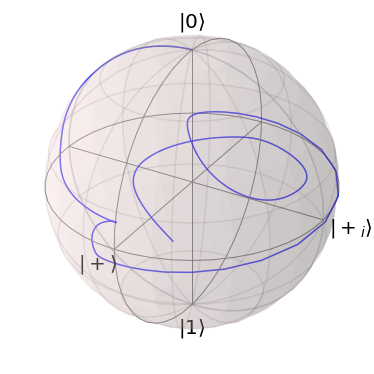

In [10]:
optimizer_long_pulse = create_optimizer(
    n_time_steps=realistic_pulse_samples // 20 * 15,
    time_pulse=realistic_pulse_time)
solver_long = optimizer_long_pulse.system_simulator.solvers[0]
solver_long.set_optimization_parameters(np.expand_dims(
    realistic_pulse_cut_lin_transferred, axis=1))

solver_long.plot_bloch_sphere()

optimizer_long_pulse.system_simulator.wrapped_cost_functions(np.expand_dims(
    realistic_pulse_cut_lin_transferred, axis=1))

# Recalibration

We need to include the systematic deviations of the hardware generated pulses
from the time discrete pulses into the optimization. This can be done in qopt
using a transfer function.
In general it is difficult to derive the transfer function for an experimental
setup analytically since this includes effects from the AWG, the transfer
lines, potential attenuators, modulators, filters and any other electronical
device used for the pulse generation and transmission.

In this example we will show a method to build a transfer function from
measured data. The method is simple as it only requires the step response,
and it automatically includes all devices, the signal has passed.


## Step Response


Assuming time translational invariance of the
systematic deviations, we can model the transfer function as convolution with
an appropriate kernel.
This kernel can be extracted from a step response. The required pulse is then
the Heavyside function $\Theta$. We denote the measured response a and the
kernel h.

\begin{equation}
a(t) = \int_{-\infty}^{\infty}h(\tau)\Theta(t - \tau) d\tau
=\int_{-\infty}^{t}h(\tau)d\tau
\end{equation}

And this leads to
\begin{equation}
h(t) = \frac{da}{dt}(t).
\end{equation}


In [11]:
data_file = "step_response.txt"
data_file4 = "step_response_4x.txt"
data_files = [data_file, data_file4]


opt_pulse = result.final_parameters

In [12]:
step_responses = []
step_responses_downsampled = []
dt_downsampled = 1 / 20
n_samples = 20 * 20


for file in data_files:

    with open(file) as f:
        lines = f.readlines()
    step_responses.append(np.vectorize(float)(np.asarray(lines)))
    step_response_downsampled = np.empty(shape=[n_samples], dtype=float)

    for ind in range(n_samples):
        step_response_downsampled[ind] = np.mean(
            step_responses[-1][ind * 16: (ind + 1) * 16])

    step_responses_downsampled.append(copy.deepcopy(step_response_downsampled))

We rescale the step responses to unity and cut out a trace that reproduces
the behavior.

In [13]:
a = np.mean(step_responses[0][:100])
a4 = np.mean(step_responses[1][:100])
b = np.mean(step_responses[0][8 * 20 * 16:12 * 20 * 16])
b4 = np.mean(step_responses[1][8 * 20 * 16:12 * 20 * 16])

step_responses_downsampled_corrected = [
    (step_responses_downsampled[0] - a) / (b - a),
    (step_responses_downsampled[1] - a4) / (b4 - a4)
]

Then the kernels are:

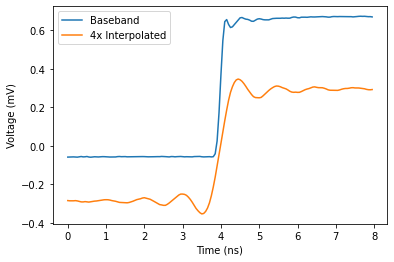

In [14]:
start_response = 2
end_response = 10
plt.plot(
    np.arange(160) / 20, step_responses_downsampled[0][
                         start_response * 20:end_response * 20] + .3)
plt.plot(
    np.arange(160) / 20, step_responses_downsampled[1][
                         start_response * 20:end_response * 20])
plt.xlabel("Time (ns)")
plt.ylabel('Voltage (mV)')
plt.legend(["Baseband", "4x Interpolated"])


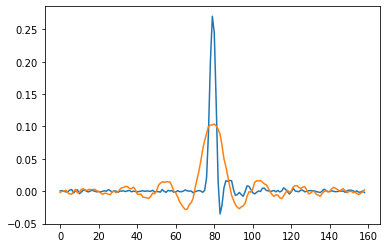

In [15]:
kernel = np.diff(
    step_responses_downsampled_corrected[0][
    start_response * 20:end_response * 20]) / dt_downsampled

kernel = kernel / np.sum(kernel)

kernel4 = np.diff(
    step_responses_downsampled_corrected[1][
    start_response * 20:end_response * 20]) / dt_downsampled
kernel4 = kernel4 / np.sum(kernel4)

plt.plot(kernel)
plt.plot(kernel4)

We start with the step response from method A.

In [16]:
oversampling_tf = OversamplingTF(
    oversampling=20, bound_type=("n", 10))
convolution_tf = ConvolutionTF(
    kernel=kernel
)
tf = ConcatenateTF(oversampling_tf, convolution_tf)

oversampling_tf4 = OversamplingTF(
    oversampling=20, bound_type=("n", 10))
convolution_tf4 = ConvolutionTF(
    kernel=kernel4
)
tf4 = ConcatenateTF(oversampling_tf4, convolution_tf4)



In [17]:

optimizer = create_optimizer(transfer_func=tf)
optimizer4 = create_optimizer(transfer_func=tf4)

result = optimizer.run_optimization(opt_pulse)
result.optim_summary.costs[-1]

array([6.41435349e-10, 6.14204708e-04])

Then continue with the response of method B. In both cases the systematic
errors can be reduced to zero within numerical accuracy and the infidelity
of 0.06% induced by the quasi-static noise shows that the recalibration
preserved the noise-cancelling property of the pulse.

In [18]:
result4 = optimizer4.run_optimization(opt_pulse)

result.optim_summary.costs[-1]

array([6.41435349e-10, 6.14204708e-04])

In [19]:
result4.optim_summary.costs[-1]

array([4.20021795e-11, 6.15040545e-04])

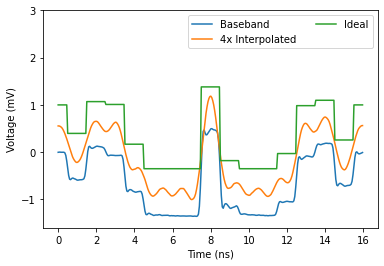

In [20]:
fig, axes_bare_pulse = plt.subplots()
axes_bare_pulse.plot(
    dt_downsampled * np.arange(16 * 20),
    optimizer.system_simulator.solvers[0].transferred_parameters)
axes_bare_pulse.plot(
    dt_downsampled * np.arange(16 * 20),
    .5 + optimizer4.system_simulator.solvers[0].transferred_parameters)
axes_bare_pulse.plot( (1 / 20) * np.arange(16 * 20),
                      1 + oversampling_tf(opt_pulse)[:, 0])
axes_bare_pulse.set_xlabel("Time (ns)")
axes_bare_pulse.set_ylabel('Voltage (mV)')
axes_bare_pulse.set_ylim(-1.6, 3)
axes_bare_pulse.legend(["Baseband", "4x Interpolated", "Ideal", ], ncol=2)

The corresponding trajectories on the Bloch sphere resemble the trajectory
before calibration.

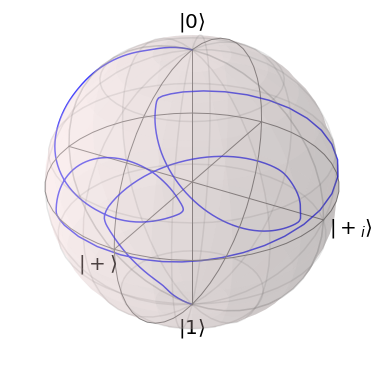

In [21]:
optimizer.system_simulator.solvers[0].plot_bloch_sphere(
    result.final_parameters)


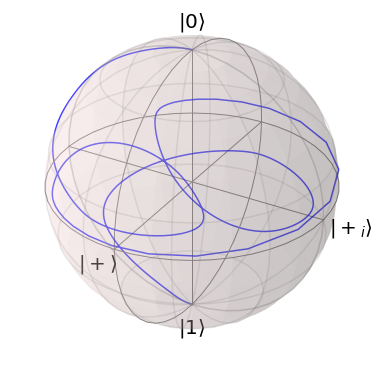

In [22]:
optimizer4.system_simulator.solvers[0].plot_bloch_sphere(
    result4.final_parameters)



